In [67]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import geopandas as gpd 
from pyrocko import moment_tensor as mtm
from importlib import reload

import proba_modules as pm

In [75]:
PATH_VENUS_DATA = os.path.join("./data/")
PATH_VENUS = os.path.join(f"{PATH_VENUS_DATA}wrinkle_ridges")
VENUS_wrinkles = dict(wrinkles=gpd.read_file(f"{PATH_VENUS}/wrinkle_ridges.shp"))

PATH_VENUS_DATA = os.path.join("./data/")
PATH_VENUS = os.path.join(f"{PATH_VENUS_DATA}Venus_data/tectonic_settings_Venus")
VENUS_tectonic = {
    'corona': gpd.read_file(f"{PATH_VENUS}/corona.shp"),
    'rift': gpd.read_file(f"{PATH_VENUS}/rifts.shp"),
    'ridge': gpd.read_file(f"{PATH_VENUS}/ridges.shp"),
}

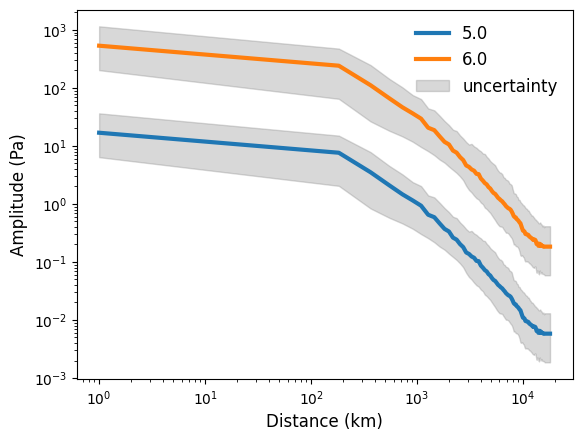

In [7]:
file_curve = './data/GF_data/GF_Dirac_1Hz_all.csv'
TL_new, TL_new_qmin, TL_new_qmax = pm.get_TL_curves(file_curve, dist_min=100., rho0=67., rhob=2.792, cb=304., use_savgol_filter=True, plot=True, scalar_moment=10e6)

In [37]:
def rate_from_slope(mw, slope, intercept):
    return 10**(np.log10(mtm.magnitude_to_moment(mw))*slope+intercept)

def return_number_per_cat_and_setting(pd_slopes, cat_quake, setting):
    slope = pd_slopes.loc[(pd_slopes.type_setting==setting)&(pd_slopes.type_unknown=='slope'), cat_quake].iloc[0]
    intercept = pd_slopes.loc[(pd_slopes.type_setting==setting)&(pd_slopes.type_unknown=='intercept'), cat_quake].iloc[0]
    func = lambda mw: rate_from_slope(mw, slope, intercept)
    return func

def return_number_per_cat_and_setting_wrinkles(pd_slopes, cat_quake, setting):

    popt = pd_slopes.loc[(pd_slopes.type_setting==setting), cat_quake].values
    poly1d = np.poly1d(popt)
    func = lambda mw: 10**poly1d(mw)
    
    return func

file_slopes = './data/Venus_data/distribution_venus_per_mw.csv'
pd_slopes = pm.get_slopes(file_slopes)

file_slopes = './data/wrinkle_ridges/distribution_venus_per_mw_wrinkles.csv'
pd_slopes_wrinkles = pm.get_slopes(file_slopes)

,type_unknown,wrinkle_ridges,type_setting
0,poly_0,-0.005872,wrinkle_ridges
1,poly_1,0.153761,wrinkle_ridges
2,poly_2,-1.571284,wrinkle_ridges
3,poly_3,7.776000,wrinkle_ridges
4,poly_4,-19.078692,wrinkle_ridges
5,poly_5,20.545492,wrinkle_ridges


Processing region corona


100%|██████████| 548/548 [00:08<00:00, 67.53it/s] 


Processing region rift


100%|██████████| 57/57 [00:01<00:00, 49.00it/s]


Processing region ridge


100%|██████████| 193/193 [00:01<00:00, 99.13it/s] 


Processing region wrinkles


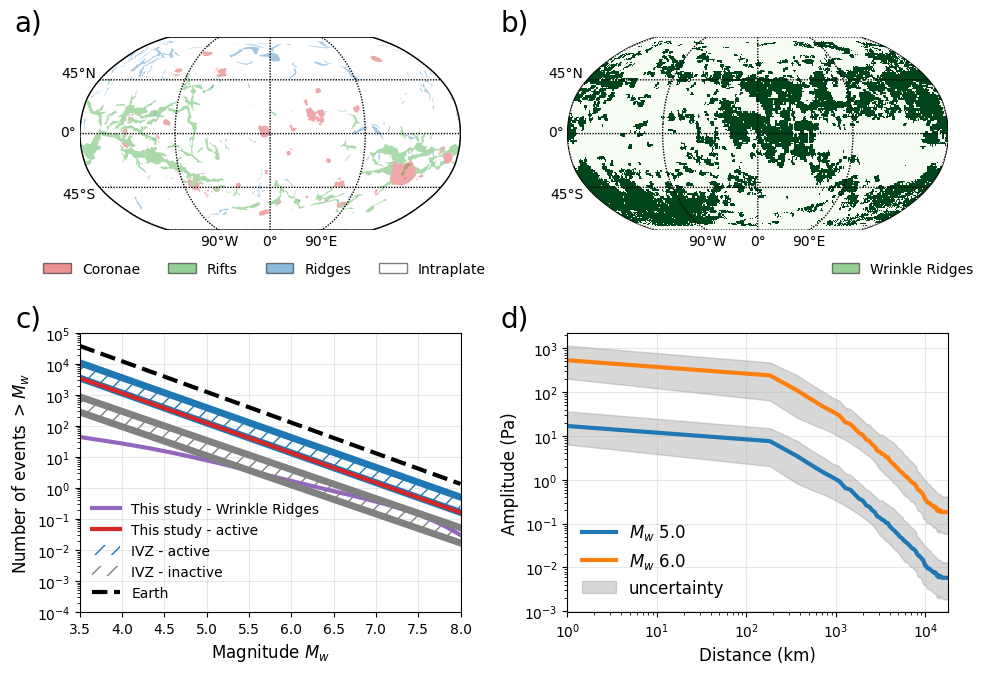

In [81]:
reload(pm)

fontsize_label = 20.

fig = plt.figure(figsize=(10,7))
grid = fig.add_gridspec(2, 2)

ax = fig.add_subplot(grid[0, 0])
m = Basemap(projection='robin', lon_0=0, ax=ax)
m.scatter(0., 0., latlon=True, s=0.1)
pm.plot_regions(m, ax, VENUS_tectonic, use_active_corona=True)
ax.text(-0.1, 1., 'a)', fontsize=fontsize_label, ha='right', va='bottom', transform=ax.transAxes)

ax = fig.add_subplot(grid[0, 1])
m = Basemap(projection='robin', lon_0=0, ax=ax)
m.scatter(0., 0., latlon=True, s=0.1)
pm.plot_regions(m, ax, VENUS_wrinkles, use_active_corona=True)
ax.text(-0.1, 1., 'b)', fontsize=fontsize_label, ha='right', va='bottom', transform=ax.transAxes)

ax = fig.add_subplot(grid[1, 0])
mw = np.linspace(3.5, 8., 100)
scenarios = ['active_low_min', 'active_low_max', 'inactive_min', 'inactive_max']
colors = {'active_low_min': 'tab:blue', 'active_low_max': 'tab:blue', 'inactive_min': 'grey', 'inactive_max': 'grey'}
selected_scenario = 'active_low_min'

f_rate = return_number_per_cat_and_setting_wrinkles(pd_slopes_wrinkles, 'wrinkle_ridges', 'wrinkle_ridges')
ax.plot(mw, f_rate(mw), color='tab:purple', linewidth=3., label=f'This study - Wrinkle Ridges')
for iscenario, scenario in enumerate(scenarios):
    
    rate = [0] * mw
    for region in pd_slopes.loc[:, ~pd_slopes.columns.str.contains('type_')].columns:
        if 'inactive' in scenario and not region == 'intraplate':
            continue
        f_rate = return_number_per_cat_and_setting(pd_slopes, region, scenario)
        rate += f_rate(mw)
    
    if 'min' in scenario:
        min_vals = rate.copy()
    
    if 'max' in scenario:
        max_vals = rate.copy()

    if (iscenario+1)%2 == 0:
        ax.fill_between(mw, min_vals, max_vals, label=f"IVZ - {' '.join(scenario.split('_')[0:1])}", color=colors[scenario], hatch='//', edgecolor='None',alpha=0.,)

    ax.plot(mw, rate, color=colors[scenario], linewidth=5.)
    if scenario == selected_scenario:
        ax.plot(mw, rate, color='tab:red', linewidth=3., label=f'This study - {" ".join(scenario.split("_")[0:1])}')

slope_earth, intercept_earth = -0.6590366497863146, 14.005110447994516
ax.plot(mw, rate_from_slope(mw, slope_earth, intercept_earth), color='black', linestyle='--', linewidth=3., label='Earth')
ax.grid(alpha=0.3)
ax.set_yscale('log')
ax.legend(frameon=False, loc='lower left', ncol=1)
ax.set_xlabel('Magnitude $M_w$', fontsize=12.)
ax.set_ylabel('Number of events $> M_w$', fontsize=12.)
ax.set_ylim([1e-4, 1e5])
ax.set_xlim([mw.min(), mw.max()])
ax.text(-0.1, 1., 'c)', fontsize=fontsize_label, ha='right', va='bottom', transform=ax.transAxes)

ax = fig.add_subplot(grid[1, 1])
dists = np.linspace(1., 18e3, 100)
mags = [5., 6.]
noise_level = 5e-2
for imag, mag in enumerate(mags):
    label = dict()
    if imag == len(mags)-1:
        label['label'] = 'uncertainty'
    ax.plot(dists, TL_new(dists, mag)/noise_level, label=f'$M_w$ {mag}', linewidth=3.)
    ax.fill_between(dists, TL_new_qmin(dists, mag)/noise_level, TL_new_qmax(dists, mag)/noise_level, color='grey', alpha=0.3, **label)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Distance (km)', fontsize=12.)
ax.set_ylabel('Amplitude (Pa)', fontsize=12.)
ax.grid(alpha=0.3)
ax.legend(frameon=False, fontsize=12.)
ax.set_xlim([dists.min(), dists.max()])
ax.text(-0.1, 1., 'd)', fontsize=fontsize_label, ha='right', va='bottom', transform=ax.transAxes)

fig.tight_layout()

In [82]:
fig.savefig('./figures/Figure_1_seismicity.pdf')